In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import wget

In [46]:
!curl -k \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"\
-O ".\cats-and-dogs.zip"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  786M    0  881k    0     0   592k      0  0:22:39  0:00:01  0:22:38  593k
  1  786M    1 9376k    0     0  3764k      0  0:03:33  0:00:02  0:03:31 3767k
  2  786M    2 17.9M    0     0  5265k      0  0:02:33  0:00:03  0:02:30 5267k
  3  786M    3 27.3M    0     0  6249k      0  0:02:08  0:00:04  0:02:04 6251k
  4  786M    4 35.4M    0     0  6606k      0  0:02:01  0:00:05  0:01:56 7259k
  5  786M    5 43.0M    0     0  6792k      0  0:01:58  0:00:06  0:01:52 8638k
  6  786M    6 51.5M    0     0  7052k      0  0:01:54  0:00:07  0:01:47 8689k
  7  786M    7 60.7M    0     0  7323k      0  0:01:50  0:00:08  0:01:42 8759k
  8  786M    8 69.9M    0     0  7549k      0  0:01

In [47]:
local_zip = '.\kagglecatsanddogs_5340.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [48]:
abs_path = os.path.abspath(os.getcwd())

source_path_dogs = os.path.join(abs_path, ".\PetImages\Dog")
source_path_cats = os.path.join(abs_path, ".\PetImages\Cat")

# Deletes all non-image files (there are two .db files bundled into the dataset)
!find "/PetImages/Dog" -type f ! -name "*.jpg" -exec rm {} +

# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cats))} images of cats.")

There are 12501 images of dogs.
There are 12501 images of cats.


Arquivo não encontrado  - "*.jpg"


In [95]:
# Define root directory
abs_path = os.path.abspath(os.getcwd())
root_dir = os.path.join(abs_path, "cats-v-dogs")

# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path, class1, class2):
  """
  Creates directories for the train and test sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """
  training_path = os.path.join(root_path, "training")
  os.makedirs(training_path)

  validation_path = os.path.join(root_path, "validation")
  os.makedirs(validation_path)
  
  training_path_cats = os.path.join(training_path, class1)
  os.makedirs(training_path_cats)

  training_path_dogs = os.path.join(training_path, class2)
  os.makedirs(training_path_dogs)

  validation_path_cats = os.path.join(validation_path, class1)
  os.makedirs(validation_path_cats)

  validation_path_dogs = os.path.join(validation_path, class2)
  os.makedirs(validation_path_dogs)

  pass

class1 = "cats"
class2 = "dogs"    
try:
  create_train_val_dirs(root_dir, class1, class2)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [96]:
for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

C:\Users\tomas\Documents\Programacao\Python Projects\Deep Learning\cats-v-dogs\training
C:\Users\tomas\Documents\Programacao\Python Projects\Deep Learning\cats-v-dogs\validation
C:\Users\tomas\Documents\Programacao\Python Projects\Deep Learning\cats-v-dogs\training\cats
C:\Users\tomas\Documents\Programacao\Python Projects\Deep Learning\cats-v-dogs\training\dogs
C:\Users\tomas\Documents\Programacao\Python Projects\Deep Learning\cats-v-dogs\validation\cats
C:\Users\tomas\Documents\Programacao\Python Projects\Deep Learning\cats-v-dogs\validation\dogs


In [100]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE, DATASET_RATIO):
  """
  Splits the data into train and test sets
  
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """

  source_directory = os.listdir(SOURCE_DIR)
  filtered_list = source_directory.copy()
  #Finding files with zero lenght and removing it from list
  zero_lenght_files = []
  for i in list(source_directory):
    if os.path.getsize(os.path.join(SOURCE_DIR,i)) == 0:
      print(i, "is zero length, so ignoring.")
      zero_lenght_files.append(source_directory.index(i))
  
  for i in sorted(zero_lenght_files, reverse=True):
    del filtered_list[i]

  #Sampling filtered list
  random_list = random.sample(filtered_list, int(len(filtered_list)*DATASET_RATIO))
  training_index = int(len(random_list) * split_size)
  training_list = random_list[0:training_index]

  for i in training_list:
    copyfile(os.path.join(SOURCE_DIR,i),os.path.join(TRAINING_DIR,i))
  
  validation_list = random_list[training_index:]
  for i in validation_list:
    copyfile(os.path.join(SOURCE_DIR,i),os.path.join(VALIDATION_DIR,i))


  pass

In [102]:
# Define paths
root_path = os.path.join(abs_path, "cats-v-dogs")
training_path = os.path.join(root_path, "training")
validation_path = os.path.join(root_path, "validation")
training_path_cats = os.path.join(training_path, class1)
training_path_dogs = os.path.join(training_path, class2)
validation_path_cats = os.path.join(validation_path, class1)
validation_path_dogs = os.path.join(validation_path, class2)

# Empty directories in case you run this cell multiple times
if len(os.listdir(training_path_cats)) > 0:
  for file in os.scandir(training_path_cats):
    os.remove(file.path)
if len(os.listdir(training_path_dogs)) > 0:
  for file in os.scandir(training_path_dogs):
    os.remove(file.path)
if len(os.listdir(validation_path_cats)) > 0:
  for file in os.scandir(validation_path_cats):
    os.remove(file.path)
if len(os.listdir(validation_path_dogs)) > 0:
  for file in os.scandir(validation_path_dogs):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .9
# Define proportion of original dataset to be used 
DATASET_RATIO = 1

# Run the function
split_data(source_path_cats, training_path_cats, validation_path_cats, split_size,DATASET_RATIO)
split_data(source_path_dogs, training_path_dogs, validation_path_dogs, split_size,DATASET_RATIO)

# Check that the number of images matches the expected output

print(f"\n\nOriginal cat's directory has {len(os.listdir(source_path_cats))} images")
print(f"Original dog's directory has {len(os.listdir(source_path_dogs))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(training_path_cats))} images of cats for training")
print(f"There are {len(os.listdir(training_path_dogs))} images of dogs for training")
print(f"There are {len(os.listdir(validation_path_cats))} images of cats for validation")
print(f"There are {len(os.listdir(validation_path_dogs))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12501 images
Original dog's directory has 12501 images

There are 11250 images of cats for training
There are 11250 images of dogs for training
There are 1250 images of cats for validation
There are 1250 images of dogs for validation


In [53]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  # Instantiate the ImageDataGenerator class
  train_datagen = ImageDataGenerator(rescale =1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class
  validation_datagen = ImageDataGenerator(rescale =1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))

  return train_generator, validation_generator

In [54]:
train_generator, validation_generator = train_val_generators(training_path, validation_path)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [23]:
def create_model():
  # DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
  # USE AT LEAST 3 CONVOLUTION LAYERS

  ### START CODE HERE

  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation= 'relu', input_shape = (150,150,3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(32, (3,3), activation= 'relu', input_shape = (150,150,3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation= 'relu', input_shape = (150,150,3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3,3), activation= 'relu', input_shape = (150,150,3)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')

  ])


  model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  ### END CODE HERE

  return model

In [24]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       36992     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [26]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=7,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/7
1125/1125 [==============================] - 281s 249ms/step - loss: 0.5980 - accuracy: 0.6648 - val_loss: 0.5236 - val_accuracy: 0.7388
Epoch 2/7
1125/1125 [==============================] - 294s 261ms/step - loss: 0.4612 - accuracy: 0.7842 - val_loss: 0.3897 - val_accuracy: 0.8260
Epoch 3/7
1125/1125 [==============================] - 281s 250ms/step - loss: 0.3744 - accuracy: 0.8331 - val_loss: 0.3438 - val_accuracy: 0.8452
Epoch 4/7
1125/1125 [==============================] - 279s 248ms/step - loss: 0.3089 - accuracy: 0.8688 - val_loss: 0.2784 - val_accuracy: 0.8828
Epoch 5/7
1125/1125 [==============================] - 284s 253ms/step - loss: 0.2586 - accuracy: 0.8946 - val_loss: 0.2938 - val_accuracy: 0.8732
Epoch 6/7
1125/1125 [==============================] - 289s 257ms/step - loss: 0.2125 - accuracy: 0.9136 - val_loss: 0.2929 - val_accuracy: 0.8884
Epoch 7/7
1125/1125 [==============================] - 301s 267ms/step - loss: 0.1771 - accuracy: 0.9306 - val_loss: 0

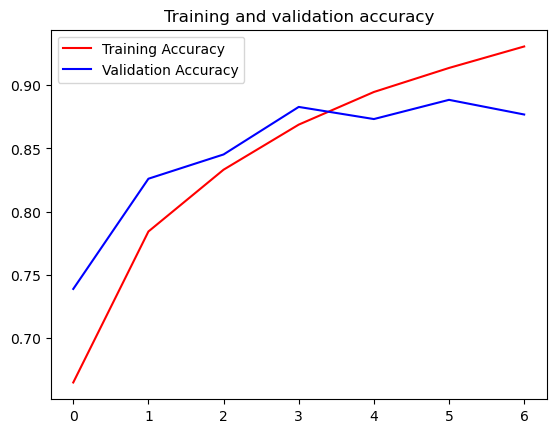

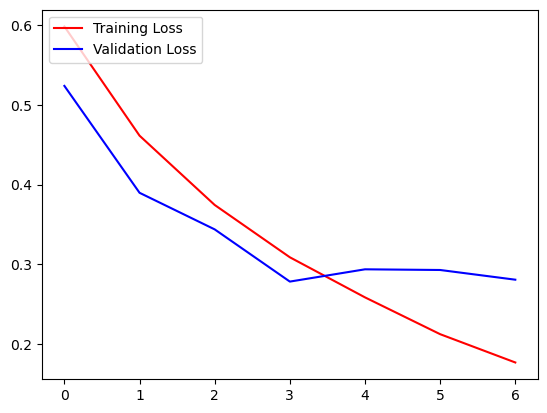

In [29]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend(loc="upper left")
plt.show()

In [30]:
## Creating generator with image augmentation

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  train_datagen = ImageDataGenerator(rescale =1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale =1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  
  return train_generator, validation_generator


In [31]:
train_generator, validation_generator = train_val_generators(training_path, validation_path)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [32]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=7,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/7
1125/1125 [==============================] - 360s 319ms/step - loss: 0.6623 - accuracy: 0.5967 - val_loss: 0.5642 - val_accuracy: 0.7020
Epoch 2/7
1125/1125 [==============================] - 365s 324ms/step - loss: 0.5992 - accuracy: 0.6757 - val_loss: 0.5242 - val_accuracy: 0.7452
Epoch 3/7
1125/1125 [==============================] - 359s 319ms/step - loss: 0.5553 - accuracy: 0.7185 - val_loss: 0.4341 - val_accuracy: 0.8052
Epoch 4/7
1125/1125 [==============================] - 363s 323ms/step - loss: 0.5155 - accuracy: 0.7504 - val_loss: 0.4086 - val_accuracy: 0.8216
Epoch 5/7
1125/1125 [==============================] - 351s 312ms/step - loss: 0.4792 - accuracy: 0.7731 - val_loss: 0.4870 - val_accuracy: 0.7732
Epoch 6/7
1125/1125 [==============================] - 354s 314ms/step - loss: 0.4518 - accuracy: 0.7897 - val_loss: 0.3224 - val_accuracy: 0.8600
Epoch 7/7
1125/1125 [==============================] - 361s 321ms/step - loss: 0.4267 - accuracy: 0.8082 - val_loss: 0

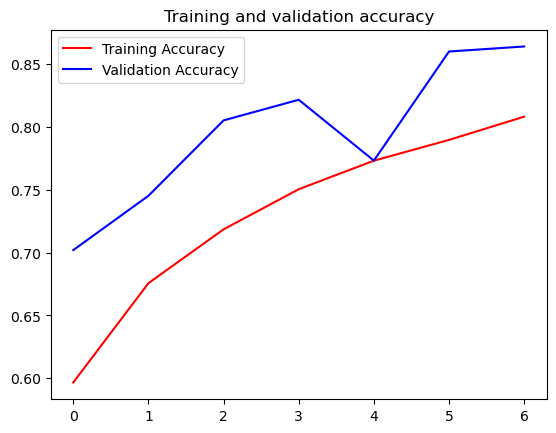

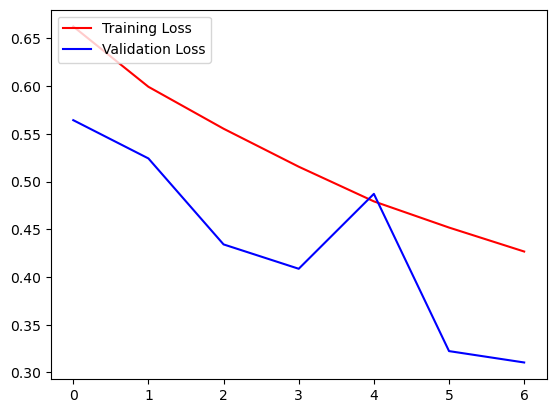

In [33]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label = "Training Accuracy")
plt.plot(epochs, val_acc, 'b', label = "Validation Accuracy")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label = "Training Loss")
plt.plot(epochs, val_loss, 'b', label = "Validation Loss")
plt.legend(loc="upper left")
plt.show()

## Transfer learning 

In [55]:
# Download the pre-trained weights.
!curl -k \
    "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"\
-O ".\"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 83.8M    0 91815    0     0   129k      0  0:11:01 --:--:--  0:11:01  129k
  8 83.8M    8 7102k    0     0  4350k      0  0:00:19  0:00:01  0:00:18 4352k
 17 83.8M   17 14.7M    0     0  5725k      0  0:00:14  0:00:02  0:00:12 5726k
 28 83.8M   28 23.5M    0     0  6663k      0  0:00:12  0:00:03  0:00:09 6664k
 38 83.8M   38 32.5M    0     0  7197k      0  0:00:11  0:00:04  0:00:07 7198k
 49 83.8M   49 41.6M    0     0  7556k      0  0:00:11  0:00:05  0:00:06 8592k
 58 83.8M   58 49.1M    0     0  7598k      0  0:00:11  0:00:06  0:00:05 8659k
 68 83.8M   68 57.5M    0     0  7720k      0  0:00:11  0:00:07  0:00:04 8776k
 77 83.8M   77 64.6M    0     0  7673k      0  0:00:11  0:00:08  0:00:03 8406k
 88 83.8M   88 74.0M    0     0  7877k      0  0:00

In [56]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [57]:
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_110 (Conv2D)         (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_110[0][0]']          
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

In [58]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [59]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [60]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model
  
  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from
    
  Returns:
    last_output: output of the model's last layer 
  """
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)

  return last_output

In [61]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [68]:
def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model
  
  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model
    
  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation = 'relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout (0.2) (x)  
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation = 'sigmoid')(x)        

  # Create the complete model by using the Model class
  # Append the dense network to the base model
  model = Model(inputs=pre_trained_model.inputs, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])
  
  return model

In [118]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


In [104]:
#Defining a smaller dataset to speed up training

# Define root directory
abs_path = os.path.abspath(os.getcwd())
root_dir = os.path.join(abs_path, "cats-v-dogs_small")


# Empty directory to prevent FileExistsError is the function is run several times
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

class1 = "cats_small"
class2 = "dogs_small"    
try:
  create_train_val_dirs(root_dir, class1, class2)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

# Define paths
root_path = root_dir
training_path = os.path.join(root_path, "training")
validation_path = os.path.join(root_path, "validation")
training_path_cats = os.path.join(training_path, class1)
training_path_dogs = os.path.join(training_path, class2)
validation_path_cats = os.path.join(validation_path, class1)
validation_path_dogs = os.path.join(validation_path, class2)

# Define proportion of images used for training
split_size = .9
DATASET_RATIO = 0.3

# Run the function
split_data(source_path_cats, training_path_cats, validation_path_cats, split_size,DATASET_RATIO)
split_data(source_path_dogs, training_path_dogs, validation_path_dogs, split_size,DATASET_RATIO)

# Check that the number of images matches the expected output

print(f"\n\nOriginal cat's directory has {len(os.listdir(source_path_cats))} images")
print(f"Original dog's directory has {len(os.listdir(source_path_dogs))} images\n")

# Training and validation splits
print(f"There are {len(os.listdir(training_path_cats))} images of cats for training")
print(f"There are {len(os.listdir(training_path_dogs))} images of dogs for training")
print(f"There are {len(os.listdir(validation_path_cats))} images of cats for validation")
print(f"There are {len(os.listdir(validation_path_dogs))} images of dogs for validation")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Original cat's directory has 12501 images
Original dog's directory has 12501 images

There are 3375 images of cats for training
There are 3375 images of dogs for training
There are 375 images of cats for validation
There are 375 images of dogs for validation


In [111]:
train_generator, validation_generator = train_val_generators(training_path, validation_path)

Found 6750 images belonging to 2 classes.
Found 750 images belonging to 2 classes.


In [119]:
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 7,
                    verbose = 1)

Epoch 1/7
338/338 [==============================] - 199s 570ms/step - loss: 0.1393 - accuracy: 0.9431 - val_loss: 0.1001 - val_accuracy: 0.9627
Epoch 2/7
338/338 [==============================] - 211s 615ms/step - loss: 0.0364 - accuracy: 0.9868 - val_loss: 0.0996 - val_accuracy: 0.9693
Epoch 3/7
338/338 [==============================] - 215s 628ms/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.1124 - val_accuracy: 0.9640
Epoch 4/7
338/338 [==============================] - 210s 615ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.1198 - val_accuracy: 0.9587
Epoch 5/7
338/338 [==============================] - 204s 594ms/step - loss: 4.2762e-04 - accuracy: 1.0000 - val_loss: 0.1170 - val_accuracy: 0.9693
Epoch 6/7
338/338 [==============================] - 202s 588ms/step - loss: 1.4399e-04 - accuracy: 1.0000 - val_loss: 0.1257 - val_accuracy: 0.9680
Epoch 7/7
338/338 [==============================] - 210s 611ms/step - loss: 8.6294e-05 - accuracy: 1.0000 - val_loss: 0.1

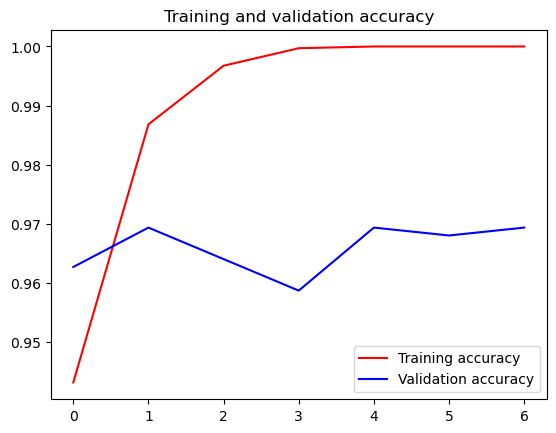

<Figure size 640x480 with 0 Axes>

In [120]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()